### 8.	Comparing the results of different machine learning models and selecting the best model

The next step is to select the best machine learning model, this will be done by selecting 9 machine learning regressors and select the best one by comparing R2, mean absolute error and mean absolute percentage error.

In [1]:
#Importing the related libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
sb.set()
from sklearn.preprocessing import PowerTransformer, QuantileTransformer, StandardScaler,OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import HistGradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import BaggingRegressor

from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, r2_score
from sklearn.model_selection import GridSearchCV

In [2]:
#Importing the data sample

data = pd.read_csv('All wells-final.csv')
data.head(3)

,FIELD,P/F,WELL,DATE,WHP,WHT,Tr,Ɣw,Pr,Pr-Pb,Reservoir,Tubing_type,WC,I.GAS,D/S,BFPD,BOPD
0,GS324,324,EDFU-A2,8-May-18,145,137,288,1.186,2585,265,Nezzazat Edfu,Normal 4.5 short*3.5,18.0,1.6,835,1521,1247
1,GS324,324,EDFU-A2,9-May-18,175,135,288,1.186,2561,241,Nezzazat Edfu,Normal 4.5 short*3.5,18.0,1.7,765,1300,1066
2,GS324,324,EDFU-A3,14-Sep-16,185,113,252,1.102,1748,98,Lower Rudies Edfu,Normal 4.5 short*3.5,1.0,1.3,775,750,743


In [3]:
#adding well type column
data['Well_type'] = data['I.GAS'].apply(lambda x:"NF" if x == 0 else "GL")

In [4]:
data.columns

Index(['FIELD', 'P/F', 'WELL', 'DATE', 'WHP', 'WHT', 'Tr', 'Ɣw', 'Pr', 'Pr-Pb',
       'Reservoir', 'Tubing_type', 'WC', 'I.GAS', 'D/S', 'BFPD', 'BOPD',
       'Well_type'],
      dtype='object')

In [5]:
#dropping unnecessary columns for the models & splitting the date
columns_to_drop = ['FIELD', 'P/F', 'WELL', 'DATE','Pr-Pb','Reservoir','BFPD', 'BOPD']
targets = data['BFPD']
inputs = data.drop(columns_to_drop, axis=1)
X_train, X_test, y_train, y_test = train_test_split(inputs, targets, test_size=0.2, random_state=1)

In [6]:
#saving the train and test sets
X_train.to_csv('X_train.csv')
X_test.to_csv('X_test.csv')
y_train.to_csv('y_train.csv')
y_test.to_csv('y_test.csv')

In [7]:
X_train.columns

Index(['WHP', 'WHT', 'Tr', 'Ɣw', 'Pr', 'Tubing_type', 'WC', 'I.GAS', 'D/S',
       'Well_type'],
      dtype='object')

In [8]:
#creating two column transformers with and without standarization steps to be used for different models
ct_st = ColumnTransformer(
    [("one_he", OneHotEncoder(drop='first'), ["Tubing_type", 'Well_type']),
     ("bc", PowerTransformer(method='box-cox'), ["WHP","WHT"]),
    ("qt", QuantileTransformer(n_quantiles=500,output_distribution='normal'), ["Tr","Ɣw","Pr","WC"]),
    ("yj", PowerTransformer(method='yeo-johnson'), ["I.GAS","D/S"]),
    ("st", StandardScaler(), ["WHP","WHT","Tr","Ɣw","Pr","WC","I.GAS","D/S"])])

ct = ColumnTransformer(
    [("one_he", OneHotEncoder(drop='first'), ["Tubing_type", 'Well_type']),
     ("bc", PowerTransformer(method='box-cox'), ["WHP","WHT"]),
    ("qt", QuantileTransformer(n_quantiles=500,output_distribution='normal'), ["Tr","Ɣw","Pr","WC"]),
    ("yj", PowerTransformer(method='yeo-johnson'), ["I.GAS","D/S"])])

In [9]:
#selecting the models

reg_lin = LinearRegression()
reg_rid = Ridge()
reg_svm = SVR(kernel = 'rbf')
reg_dec = DecisionTreeRegressor()
reg_rand = RandomForestRegressor()
reg_ex = ExtraTreesRegressor()
reg_hist = HistGradientBoostingRegressor()
reg_xgb = XGBRegressor()
reg_bag = BaggingRegressor()
models_list = [reg_lin, reg_rid, reg_svm, reg_dec, reg_rand, reg_ex, reg_hist, reg_xgb, reg_bag]

r2_train = []
r2_test = []
mean_abs_error = []
mean_sq_error = []
mean_abs_percent_error = []

In [10]:
for reg in models_list:
    if reg is reg_lin or reg is reg_rid or reg is reg_svm:
        pipeline = Pipeline(steps=[('t', ct_st), ('m',reg)])
        
    else:
        pipeline = Pipeline(steps=[('t', ct), ('m',reg)])

    pipeline.fit(X_train, y_train)
    y_hat_train = pipeline.predict(X_train)
    y_hat_test = pipeline.predict(X_test)
    
    r2_train.append(round(r2_score(y_train, y_hat_train), 4))
    r2_test.append(round(r2_score(y_test, y_hat_test), 4))
    mean_abs_error.append(round(mean_absolute_error(y_test, y_hat_test)))
    mean_sq_error.append(round(np.sqrt(mean_squared_error(y_test, y_hat_test))))
    mean_abs_percent_error.append(round(mean_absolute_percentage_error(y_test, y_hat_test), 3)*100)
    print(reg)

LinearRegression()
Ridge()
SVR()
DecisionTreeRegressor()
RandomForestRegressor()
ExtraTreesRegressor()
HistGradientBoostingRegressor()
XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)
BaggingRegressor()


In [11]:
#Creating table for models performance
regression_models = ['Linear regressor', 'Ridge regressor', 'Support Vector Machine', 'Decision Tree regressor',
                     'Random Forests regressor', 'Extra Trees regressor', 'Hist Gradient Boosting regressor',
                     'XGB regressor', 'Bagging Regressor']

Models = pd.DataFrame({'model':regression_models,
                  'R2 train':r2_train,
                  'R2 test': r2_test,
                  'Mean Absolute Error':mean_abs_error,
                  'Mean Squared Error': mean_sq_error,
                  'Mean Absolute Percent Error': mean_abs_percent_error})

Models.index = np.arange(1, len(Models)+1)

In [12]:
Models = Models.sort_values(by='Mean Absolute Percent Error').reset_index(drop=True)
Models.index = np.arange(1, len(Models)+1)
Models

,model,R2 train,R2 test,Mean Absolute Error,Mean Squared Error,Mean Absolute Percent Error
1,Extra Trees regressor,0.9999,0.9720,205,300,11.7
2,Random Forests regressor,0.9942,0.9673,222,324,13.2
3,XGB regressor,0.9945,0.9657,231,331,13.2
4,Hist Gradient Boosting regressor,0.9782,0.9643,241,338,13.9
5,Bagging Regressor,0.9911,0.9597,243,360,14.1
6,Decision Tree regressor,0.9999,0.9394,289,441,15.8
7,Linear regressor,0.8496,0.8668,501,654,28.9
8,Ridge regressor,0.8485,0.8652,508,657,29.1
9,Support Vector Machine,0.1641,0.1556,1264,1645,87.9


As shown from the above table, Extra Trees regressor showed the best performance with 11.0% average absolute error and 0.972 R2 score.

In [13]:
reg_ex = ExtraTreesRegressor()
reg_ex.fit(ct.fit_transform(X_train), y_train)
y_hat_train = reg_ex.predict(ct.transform(X_train))
y_hat_test = reg_ex.predict(ct.transform(X_test))

In [14]:
plt.rcParams["figure.figsize"]= 5,4

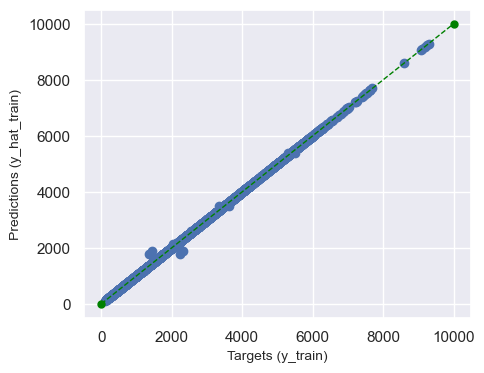

In [15]:
#Plotting train data results

plt.scatter(y_train, y_hat_train)
plt.xlabel('Targets (y_train)',size=10)
plt.ylabel('Predictions (y_hat_train)',size=10)
plt.plot([0,10000], [0,10000], color='green', marker='o', linestyle='dashed', linewidth=1, markersize=5);

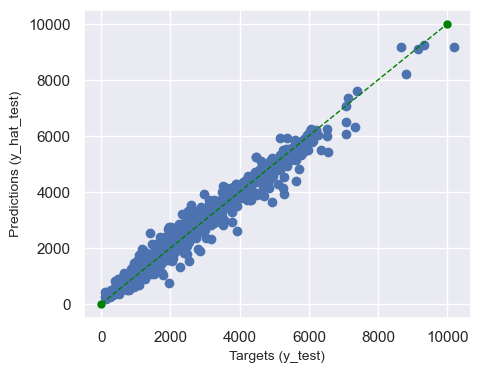

In [16]:
#Plotting test data results

plt.scatter(y_test, y_hat_test)
plt.xlabel('Targets (y_test)',size=10)
plt.ylabel('Predictions (y_hat_test)',size=10)
plt.plot([0,10000], [0,10000], color='green', marker='o', linestyle='dashed', linewidth=1, markersize=5);

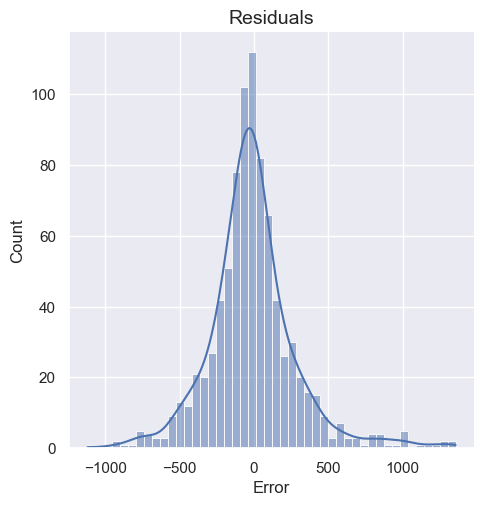

In [17]:
#plotting the error distribution

sb.displot(y_test - y_hat_test, kde=True)
plt.xlabel("Error")
plt.title("Residuals", size=14);

In [18]:
pd.get_dummies(data, drop_first=True, columns=['Tubing_type','Well_type']).columns

Index(['FIELD', 'P/F', 'WELL', 'DATE', 'WHP', 'WHT', 'Tr', 'Ɣw', 'Pr', 'Pr-Pb',
       'Reservoir', 'WC', 'I.GAS', 'D/S', 'BFPD', 'BOPD',
       'Tubing_type_Big bore 5.5 long*4.5',
       'Tubing_type_Big bore 5.5 long*4.5*3.5',
       'Tubing_type_Big bore 5.5 short*(4.5*3.5 joints)',
       'Tubing_type_Normal 4.5 long*3.5', 'Tubing_type_Normal 4.5 short*3.5',
       'Tubing_type_Slim (4.5*3.5 joints)*2.875',
       'Tubing_type_Slim 4.5 long*3.5*2.875', 'Well_type_NF'],
      dtype='object')

In [19]:
new_columns = ['Tubing_type_Big bore 5.5 long*4.5',
       'Tubing_type_Big bore 5.5 long*4.5*3.5',
       'Tubing_type_Big bore 5.5 short*(4.5*3.5 joints)',
       'Tubing_type_Normal 4.5 long*3.5', 'Tubing_type_Normal 4.5 short*3.5',
       'Tubing_type_Slim (4.5*3.5 joints)*2.875',
       'Tubing_type_Slim 4.5 long*3.5*2.875', 'Well_type_NF''FIELD', 'P/F', 'WELL', 'DATE', 'WHP', 'WHT', 'Tr', 'Ɣw', 'Pr', 'Pr-Pb',
       'Reservoir', 'WC', 'I.GAS', 'D/S', 'BFPD', 'BOPD']

final_columns = []
for i in new_columns:
    if i not in columns_to_drop:
        final_columns.append(i)

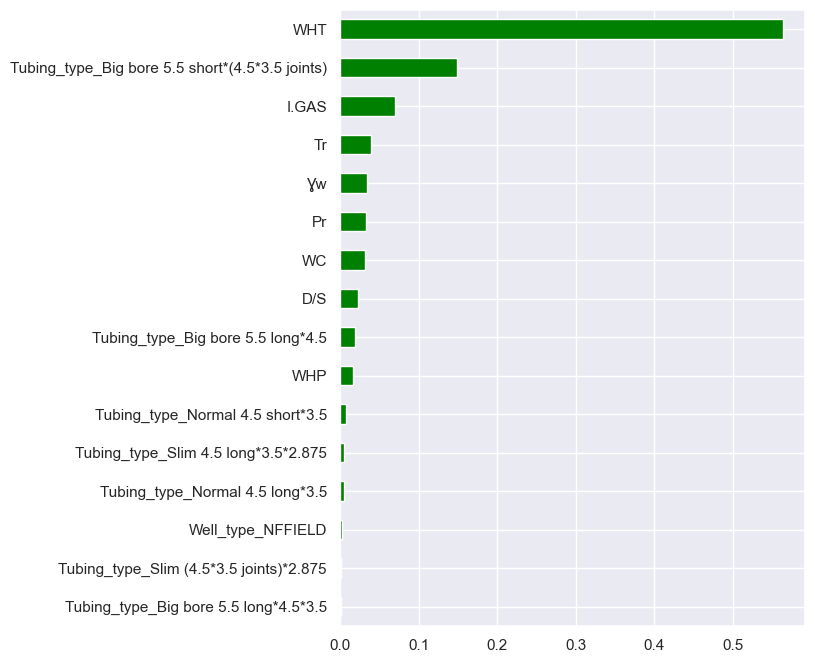

In [20]:
#Embedded Tree Feature Importance
importances_rf = pd.Series(reg_ex.feature_importances_, index = final_columns)
sorted_importances_rf = importances_rf.sort_values()
sorted_importances_rf
plt.figure(figsize = [6, 8])
sorted_importances_rf.plot(kind='barh', color='green');

As shown above, WHT & IG are the most important parameters for Extra Trees regressor.

### 9.	Optimizing the model by hyperparameters fine tuning

The next step is to fine tune Extra trees regressor hyper parameters, this step is done using Grid Searh library.

In [21]:
n_estimators = [30, 50, 100, 200, 300]
max_features = [1.0, 'sqrt', 'log2', 5, 6, 8, 10, 12, 14]
min_samples_leaf = [4, 5, 6, 8, 10, 20, 30]
#selecting minimum value of sample leaf 4 to prevent overfitting
ccp_alphas = np.arange(0, 0.25, 0.005).tolist()

parameters = {
    'n_estimators': n_estimators,
    'max_features': max_features, 
    'min_samples_leaf': min_samples_leaf,
    'ccp_alpha': ccp_alphas
    }

grid = GridSearchCV(reg_ex, parameters, scoring='neg_mean_absolute_error', cv=3, verbose=2, n_jobs=-1)

results = grid.fit(ct.fit_transform(X_train), y_train)

Fitting 3 folds for each of 15750 candidates, totalling 47250 fits


In [22]:
def plot_search_results(grid):
    """
    Params: 
        grid: A trained GridSearchCV object.
    """
    ## Results from grid search
    results = grid.cv_results_
    means_test = results['mean_test_score']
    stds_test = results['std_test_score']

    ## Getting indexes of values per hyper-parameter
    masks=[]
    masks_names= list(grid.best_params_.keys())
    for p_k, p_v in grid.best_params_.items():
        masks.append(list(results['param_'+p_k].data==p_v))

    params=grid.param_grid

    ## Ploting results
    fig, ax = plt.subplots(1,len(params),sharex='none', sharey='all',figsize=(20,5))
    fig.suptitle('Score per parameter')
    fig.text(0.04, 0.5, 'MEAN SCORE', va='center', rotation='vertical')
    pram_preformace_in_best = {}
    for i, p in enumerate(masks_names):
        m = np.stack(masks[:i] + masks[i+1:])
        pram_preformace_in_best
        best_parms_mask = m.all(axis=0)
        best_index = np.where(best_parms_mask)[0]
        x = np.array(params[p])
        y_1 = np.array(means_test[best_index])
        e_1 = np.array(stds_test[best_index])
        ax[i].errorbar(x, y_1, e_1, linestyle='--', marker='o', label='test')
        ax[i].set_xlabel(p)

    plt.legend()
    plt.show()

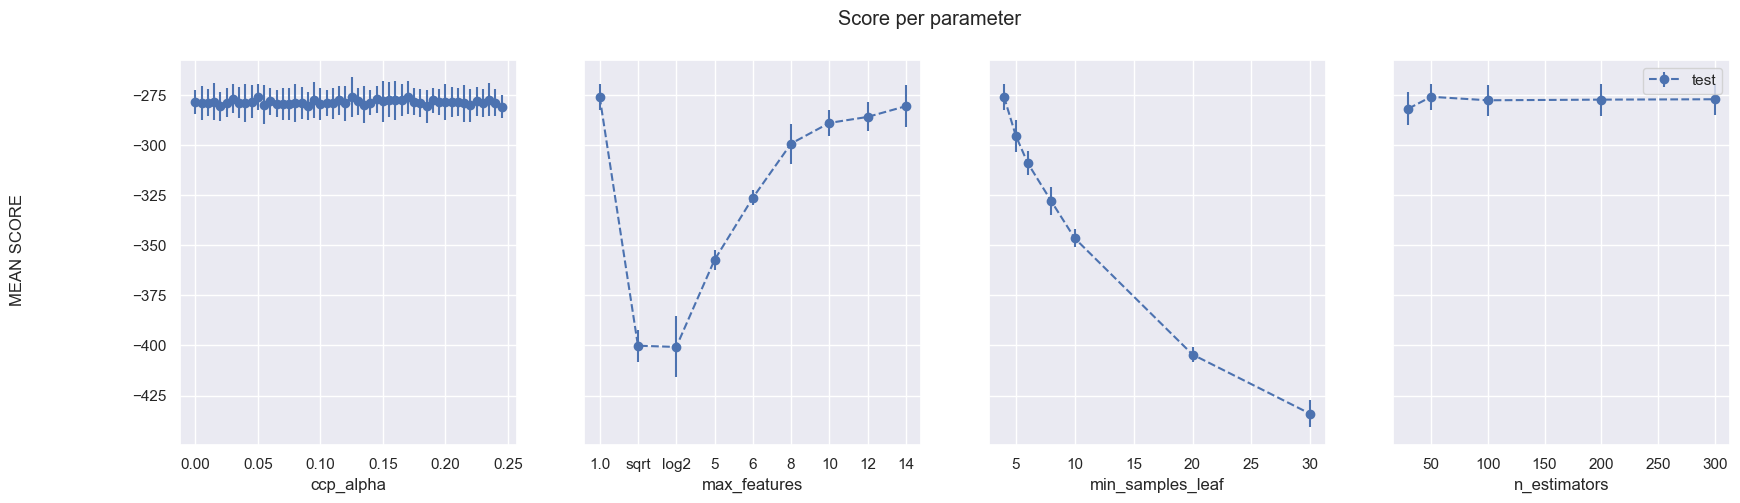

In [23]:
#Plotting grid search results
plot_search_results(results)

In [24]:
results.best_params_

{'ccp_alpha': 0.05,
 'max_features': 1.0,
 'min_samples_leaf': 4,
 'n_estimators': 50}

In [25]:
#Selecting model with best parameters
reg_ex_opt = results.best_estimator_

In [26]:
reg_ex_opt.fit(ct.transform(X_train),y_train)
y_hat_train = reg_ex_opt.predict(ct.transform(X_train))
y_hat_test = reg_ex_opt.predict(ct.transform(X_test))

In [27]:
#Printing final results
print("Mean absolute error is " + str(round(mean_absolute_error(y_test, y_hat_test))))
print("Mean square error is " + str(round(np.sqrt(mean_squared_error(y_test, y_hat_test)))))
print("Mean absolute percent error is " + str(round(mean_absolute_percentage_error(y_test, y_hat_test)*100, 1))+"%")
print("R2 test score is " + str(round(r2_score(y_train, y_hat_train), 4)))
print("R2 train score is " + str(round(r2_score(y_test, y_hat_test), 4)))

Mean absolute error is 250
Mean square error is 354
Mean absolute percent error is 14.4%
R2 test score is 0.9791
R2 train score is 0.9609


In [28]:
#creating the final pipeline
pipeline_ex = Pipeline(steps=[('t', ct), ('m',reg_ex_opt)])

In [29]:
#Saving the optimized model pipeline and column transformers
import joblib
joblib.dump(pipeline_ex, 'pipeline_ex.joblib')
joblib.dump(ct, 'column_transformer.joblib')
joblib.dump(ct_st, 'column_transformer_st.joblib')

['column_transformer_st.joblib']